In [ ]:
## Final submission by Omar Khater, Nicholas Garde, and Hailey Schmidt
## Team Nap-Time Optimizers - 'Careful Model 1'
## https://github.com/omarkhater-school/multi_modal_cgm_analysis/commit/069593af92e9c544bc573b0199fbccea95beb22a
import pandas as pd
import ast
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from sklearn.feature_selection import SelectKBest, f_regression

import matplotlib.pyplot as plt


In [2]:
def read_viome_data(path):
    viome_data = pd.read_csv(path)
    viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)
    return viome_data

def read_labels(path):
    labels = pd.read_csv(path)
    return labels

def calculate_feature_importance(preprocessor, feature_selector, model):
    """
    Calculate feature importances for a given model and preprocessor, accounting for feature selection.

    Parameters:
    - preprocessor: The fitted preprocessor object (e.g., ColumnTransformer).
    - feature_selector: The fitted feature selection object (e.g., SelectKBest).
    - model: The fitted model (supports LR, SVR, XGBoost, RF).

    Returns:
    - feature_importance_df: DataFrame with 'Feature' and 'Importance' columns.
    """
    # Extract feature names from the preprocessor
    if hasattr(preprocessor, 'get_feature_names_out'):
        all_feature_names = preprocessor.get_feature_names_out()
    else:
        raise ValueError("Feature names are not available from the preprocessor.")

    # Apply the mask from the feature selector to get selected feature names
    if hasattr(feature_selector, 'get_support'):
        selected_mask = feature_selector.get_support()
        selected_feature_names = all_feature_names[selected_mask]
    else:
        raise ValueError("Feature selector does not support feature selection mask extraction.")

    # Extract feature importances or coefficients based on the model type
    if hasattr(model, 'feature_importances_'):  # For tree-based models (RF, XGBoost)
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):  # For linear models (LR, SVR)
        # Handle multi-class or multi-output coefficients
        if len(model.coef_.shape) == 2:  # E.g., shape (n_classes, n_features)
            importances = np.mean(np.abs(model.coef_), axis=0)  # Average across classes or outputs
        else:
            importances = model.coef_
    else:
        raise ValueError("Feature importance cannot be determined for this model.")

    # Create DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    return feature_importance_df



def plot_feature_importance(feature_importance_df, top_n=20):
    """
    Plot feature importances.

    Parameters:
    - feature_importance_df: DataFrame with 'Feature' and 'Importance' columns.
    - top_n: Number of top features to display in the plot.

    Returns:
    - None: Displays a plot.
    """
    # Select the top N features
    sorted_df = feature_importance_df.head(top_n)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_df['Feature'], sorted_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()


def rmsre(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))


def plot_regression_curve(y_true, y_pred, best_model_rmsre, best_model_r2):
    """
    Plot the regression curve for predicted vs true values and display RMSRE and R².

    Parameters:
    - y_true: The true target values from the training set.
    - y_pred: The predicted target values from the model.
    - best_model_rmsre: RMSRE score of the best model.
    - best_model_r2: R² score of the best model.

    Returns:
    - None: Displays the regression plot.
    """
    # Sort values for a smooth regression line
    plt.figure(figsize=(10, 6))
    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.6, color='orange')
    
    # Reference line (y = x)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 
             linestyle='--', color='green', label='Ideal Fit (y = x)')
    
    # Add RMSRE and R² as text annotations
    plt.text(0.05, 0.95, f"RMSRE: {best_model_rmsre:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.05, 0.90, f"R²: {best_model_r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    # Add labels, legend, and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot with 1:1 Reference Line')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
label_train = pd.read_csv("../data/label_train.csv")
label_test = pd.read_csv("../data/label_test_breakfast_only.csv")

viome_train = read_viome_data('../data/demo_viome_train.csv')
viome_test = read_viome_data('../data/demo_viome_test.csv')


In [4]:
viome_train.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,61.0,181.0,91.0,90.0,78.0,12.0,2.0,3.398519,30.943704,"[-9.395216776716872, -7.315438412832852, 1.103..."
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,154.0,190.0,74.0,116.0,90.0,31.0,2.6,5.069630,26.946045,"[-11.007947281293239, -8.444134921199856, 0.28..."
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,392.0,269.0,38.0,231.0,157.0,78.0,7.1,4.586667,30.954496,"[-6.21833166351615, -5.868646092839025, -6.612..."
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,75.0,203.0,72.0,131.0,118.0,15.0,2.8,1.517037,29.300575,"[-6.7953636871125, -6.50799421035929, -1.85678..."


In [5]:
demograph_train_df = viome_train.drop(columns = ["Viome"], axis = 1)
demograph_train_df.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,61.0,181.0,91.0,90.0,78.0,12.0,2.0,3.398519,30.943704
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,154.0,190.0,74.0,116.0,90.0,31.0,2.6,5.069630,26.946045
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,392.0,269.0,38.0,231.0,157.0,78.0,7.1,4.586667,30.954496
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,75.0,203.0,72.0,131.0,118.0,15.0,2.8,1.517037,29.300575


In [6]:
demograph_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject ID                36 non-null     int64  
 1   Age                       36 non-null     int64  
 2   Gender                    36 non-null     int64  
 3   Weight                    36 non-null     float64
 4   Height                    36 non-null     float64
 5   Race                      36 non-null     object 
 6   Diabetes Status           36 non-null     int64  
 7   A1C                       36 non-null     float64
 8   Baseline Fasting Glucose  36 non-null     float64
 9   Insulin                   36 non-null     float64
 10  Triglycerides             36 non-null     float64
 11  Cholesterol               36 non-null     float64
 12  HDL                       36 non-null     float64
 13  Non-HDL                   36 non-null     float64
 14  LDL         

In [7]:
demograph_train_df.nunique()

Subject ID                  36
Age                         24
Gender                       2
Weight                      35
Height                      16
Race                         3
Diabetes Status              3
A1C                         24
Baseline Fasting Glucose    32
Insulin                     32
Triglycerides               33
Cholesterol                 34
HDL                         26
Non-HDL                     33
LDL                         31
VLDL                        21
CHO/HDL Ratio               29
HOMA-IR                     36
BMI                         36
dtype: int64

In [8]:
expanded_df = pd.DataFrame(
    viome_train['Viome'].to_list(), 
    columns=[f'Viome_{i}' for i in range(len(viome_train['Viome'][0]))])

# Combine with the original DataFrame (if needed)
df = pd.concat([demograph_train_df, expanded_df], axis=1)

In [9]:
df.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,...,Viome_17,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,...,0.348451,1.591451,0.748944,-0.017463,0.514344,-0.392209,-0.211173,-0.210122,-0.007723,-0.090217
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,...,-0.202068,-1.578614,-1.356888,0.143230,-1.742321,0.451295,0.304562,-0.049945,0.188032,-0.039500
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,...,-3.206188,-1.994911,1.867685,-1.029219,-0.412351,-0.657447,0.115855,0.093384,0.104649,0.009800
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,...,0.738694,2.938831,-2.335281,0.162024,-0.439828,0.176664,0.474702,0.034012,0.210099,0.338655


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject ID                36 non-null     int64  
 1   Age                       36 non-null     int64  
 2   Gender                    36 non-null     int64  
 3   Weight                    36 non-null     float64
 4   Height                    36 non-null     float64
 5   Race                      36 non-null     object 
 6   Diabetes Status           36 non-null     int64  
 7   A1C                       36 non-null     float64
 8   Baseline Fasting Glucose  36 non-null     float64
 9   Insulin                   36 non-null     float64
 10  Triglycerides             36 non-null     float64
 11  Cholesterol               36 non-null     float64
 12  HDL                       36 non-null     float64
 13  Non-HDL                   36 non-null     float64
 14  LDL         

In [11]:
label_train.head()

,Subject ID,Day,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,Breakfast Protein,Lunch Protein
0,1,2,448.0,830,66.0,92,10.5,42.0,22.0,17
1,1,3,608.0,435,66.0,16,10.5,14.0,66.0,66
2,1,4,712.0,555,66.0,94,42.0,13.0,22.0,12
3,1,5,902.0,355,73.0,19,42.0,15.0,66.0,32
4,1,6,268.0,1180,24.0,81,10.5,54.5,22.0,88


In [12]:
label_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Subject ID          324 non-null    int64  
 1   Day                 324 non-null    int64  
 2   Breakfast Calories  324 non-null    float64
 3   Lunch Calories      324 non-null    int64  
 4   Breakfast Carbs     324 non-null    float64
 5   Lunch Carbs         324 non-null    int64  
 6   Breakfast Fat       324 non-null    float64
 7   Lunch Fat           324 non-null    float64
 8   Breakfast Protein   324 non-null    float64
 9   Lunch Protein       324 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 25.4 KB


In [13]:
label_train["Lunch Calories"].value_counts()

Lunch Calories
830     72
435     72
555     72
355     72
1180    36
Name: count, dtype: int64

In [14]:
combined_df = label_train.merge(df, on=['Subject ID'])

In [15]:
combined_df

,Subject ID,Day,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,Breakfast Protein,Lunch Protein,...,Viome_17,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26
0,1,2,448.0,830,66.0,92,10.5,42.0,22.0,17,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
1,1,3,608.0,435,66.0,16,10.5,14.0,66.0,66,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
2,1,4,712.0,555,66.0,94,42.0,13.0,22.0,12,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
3,1,5,902.0,355,73.0,19,42.0,15.0,66.0,32,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
4,1,6,268.0,1180,24.0,81,10.5,54.5,22.0,88,...,1.183266,0.123951,1.422716,-0.201777,0.773843,-0.125457,-0.352396,-0.241578,-0.135894,-0.164389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,7,6,268.0,1180,24.0,81,10.5,54.5,22.0,88,...,-4.746553,2.002800,3.282698,-1.570438,-0.179446,0.263283,0.491576,0.502913,-0.141314,-0.414110
320,7,7,448.0,830,66.0,92,10.5,42.0,22.0,17,...,-4.746553,2.002800,3.282698,-1.570438,-0.179446,0.263283,0.491576,0.502913,-0.141314,-0.414110
321,7,8,608.0,435,66.0,16,10.5,14.0,66.0,66,...,-4.746553,2.002800,3.282698,-1.570438,-0.179446,0.263283,0.491576,0.502913,-0.141314,-0.414110
322,7,9,712.0,555,66.0,94,42.0,13.0,22.0,12,...,-4.746553,2.002800,3.282698,-1.570438,-0.179446,0.263283,0.491576,0.502913,-0.141314,-0.414110


In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject ID                324 non-null    int64  
 1   Day                       324 non-null    int64  
 2   Breakfast Calories        324 non-null    float64
 3   Lunch Calories            324 non-null    int64  
 4   Breakfast Carbs           324 non-null    float64
 5   Lunch Carbs               324 non-null    int64  
 6   Breakfast Fat             324 non-null    float64
 7   Lunch Fat                 324 non-null    float64
 8   Breakfast Protein         324 non-null    float64
 9   Lunch Protein             324 non-null    int64  
 10  Age                       324 non-null    int64  
 11  Gender                    324 non-null    int64  
 12  Weight                    324 non-null    float64
 13  Height                    324 non-null    float64
 14  Race      

In [17]:
combined_df.nunique()

Subject ID                  36
Day                          9
Breakfast Calories           5
Lunch Calories               5
Breakfast Carbs              3
Lunch Carbs                  5
Breakfast Fat                2
Lunch Fat                    5
Breakfast Protein            2
Lunch Protein                5
Age                         24
Gender                       2
Weight                      35
Height                      16
Race                         3
Diabetes Status              3
A1C                         24
Baseline Fasting Glucose    32
Insulin                     32
Triglycerides               33
Cholesterol                 34
HDL                         26
Non-HDL                     33
LDL                         31
VLDL                        21
CHO/HDL Ratio               29
HOMA-IR                     36
BMI                         36
Viome_0                     35
Viome_1                     35
Viome_2                     35
Viome_3                     35
Viome_4 

In [18]:
features = combined_df.drop(
    columns=[
        "Day", 
        "Subject ID", 
        "Lunch Calories", 
        "Lunch Carbs", 
        "Lunch Fat",
        "Lunch Protein"
        ])
target = combined_df["Lunch Calories"]

# Explicitly defining exceptions for numerical columns with low `nunique()`
numerical_exceptions = [
    'Breakfast Calories', 
    'Breakfast Carbs', 
    'Breakfast Fat', 
    'Breakfast Protein', 
    "Age", "Weight", "Height", "A1C", "Baseline Fasting Glucose",
    "Insulin", "Triglycerides", "Cholesterol", "HDL", "Non-HDL",
    "LDL", "VLDL", "CHO/HDL Ratio", "HOMA-IR", "BMI"
]

# Categorize features
categorical_columns = [
    col for col in features.columns
    if combined_df[col].nunique() < 10 and col not in numerical_exceptions
]

numerical_columns = [
    col for col in features.columns
    if col not in categorical_columns + ["Lunch Calories"]
]

# Output
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)



Categorical Columns: ['Gender', 'Race', 'Diabetes Status']
Numerical Columns: ['Breakfast Calories', 'Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein', 'Age', 'Weight', 'Height', 'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI', 'Viome_0', 'Viome_1', 'Viome_2', 'Viome_3', 'Viome_4', 'Viome_5', 'Viome_6', 'Viome_7', 'Viome_8', 'Viome_9', 'Viome_10', 'Viome_11', 'Viome_12', 'Viome_13', 'Viome_14', 'Viome_15', 'Viome_16', 'Viome_17', 'Viome_18', 'Viome_19', 'Viome_20', 'Viome_21', 'Viome_22', 'Viome_23', 'Viome_24', 'Viome_25', 'Viome_26']


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

In [20]:
# Define models and parameters
models_with_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "model__fit_intercept": [True, False]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(random_state=42, objective="reg:squarederror"),
        "params": {
            "model__n_estimators": [50, 100, 200, 300],
            "model__max_depth": [ 3, 6, 7, 8, 9, 10],
            "model__learning_rate": [.001, 0.01, 0.1, 0.2],
            "model__subsample": [.1, .4, 0.8, 1.0]
        }
    },
    "SVM (SVR)": {
        "model": SVR(),
        "params": {
            "model__kernel": ["linear"],
            "model__C": [.001, 0.1, 1, 5, 10],
            "model__gamma": ["scale", "auto"]
        }
    }
}

In [21]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

In [22]:
X_train.head()

,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein,Age,Gender,Weight,Height,Race,Diabetes Status,...,Viome_17,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26
73,608.0,66.0,10.5,66.0,34,0,186.2,67.0,Hispanic/Latino,2,...,3.645839,1.610915,-0.743516,-0.985421,-0.695481,0.646043,0.100610,0.435668,-0.018749,0.159910
181,608.0,66.0,10.5,66.0,59,1,204.8,60.0,Hispanic/Latino,3,...,0.384493,0.382582,-0.215523,0.576788,-1.114855,-2.276211,1.733990,-1.680511,-3.062497,-2.021651
17,268.0,24.0,10.5,22.0,49,1,169.2,62.0,Hispanic/Latino,1,...,0.348451,1.591451,0.748944,-0.017463,0.514344,-0.392209,-0.211173,-0.210122,-0.007723,-0.090217
24,608.0,66.0,10.5,66.0,59,1,157.0,64.0,Hispanic/Latino,3,...,-0.202068,-1.578614,-1.356888,0.143230,-1.742321,0.451295,0.304562,-0.049945,0.188032,-0.039500
146,712.0,66.0,42.0,22.0,59,1,206.2,63.5,African American,2,...,0.442699,-0.566262,0.688064,-0.504941,2.772566,4.859711,1.418702,0.041219,3.204060,-1.529950


In [23]:
y_train.value_counts()

Lunch Calories
355     61
830     57
555     57
435     55
1180    29
Name: count, dtype: int64

In [24]:
y_val.value_counts()

Lunch Calories
435     17
830     15
555     15
355     11
1180     7
Name: count, dtype: int64

## Grid Search Tuning

In [ ]:
# Evaluate each model
grid_results = []
best_model = None
best_model_name = None
lowest_rmsre = float('inf')

for model_name, model_info in models_with_params.items():
    print(f"***\nEvaluating model: {model_name}")
    # Define pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression)),
        ('model', model_info["model"])
    ])

    # Update parameter grid to include feature selection parameters
    params_with_feature_selection = {
        **model_info["params"],
        'feature_selection__k': [5, 10, 15, 20 , 25, 30, 35, 40, 50,'all']
    }

    # Grid Search
    grid_search = GridSearchCV(
        pipeline, 
        model_info["params"], 
        cv=10, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1,
        error_score='raise',
        verbose=1
    )
    try:
        grid_search.fit(X_train, y_train)

        # Best model predictions on test set
        best_cv_score = -grid_search.best_score_  # Convert back to positive MSE
        
        # Evaluate on the validation set
        y_val_pred = grid_search.best_estimator_.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        val_rmsre = rmsre(y_val, y_val_pred)

        # Store results
        result =  {
            "Model": grid_search.best_estimator_,
            "Best Parameters": grid_search.best_params_,
            "Mean CV MSE": best_cv_score,
            "Validation MSE": val_mse,
            "Validation MAE": val_mae,
            "Validation R2": val_r2,
            "Validation RMSRE": val_rmsre
        }
        if result["Validation RMSRE"] < lowest_rmsre:
            lowest_rmsre = result["Validation RMSRE"]
            best_model = grid_search.best_estimator_ 
            best_model_name = model_name

        grid_results.append(result)

    except Exception as e:
        print(f"Error with model {model_name}: {e}")
        continue


***
Evaluating model: Linear Regression
Fitting 10 folds for each of 2 candidates, totalling 20 fits
***
Evaluating model: Random Forest
Fitting 10 folds for each of 81 candidates, totalling 810 fits
***
Evaluating model: XGBoost
Fitting 10 folds for each of 384 candidates, totalling 3840 fits
***
Evaluating model: SVM (SVR)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
comparison_df_grid = pd.DataFrame(grid_results).sort_values(by="Validation RMSRE")
comparison_df_grid["Tuning Strategy"] = "Grid"
comparison_df_grid

,Model,Best Parameters,Mean CV MSE,Validation MSE,Validation MAE,Validation R2,Validation RMSRE,Tuning Strategy
0,"(ColumnTransformer(transformers=[('num', Robus...",{'model__fit_intercept': False},46435.768270,34741.524071,111.604576,0.471687,0.308920,Grid
2,"(ColumnTransformer(transformers=[('num', Robus...","{'model__learning_rate': 0.01, 'model__max_dep...",51890.031567,41363.444174,115.979636,0.370987,0.309986,Grid
3,"(ColumnTransformer(transformers=[('num', Robus...","{'model__C': 0.001, 'model__gamma': 'scale', '...",72956.335906,70029.827410,195.961598,-0.064941,0.359228,Grid
1,"(ColumnTransformer(transformers=[('num', Robus...","{'model__max_depth': 10, 'model__min_samples_l...",62713.893788,46220.701047,94.268789,0.297123,0.369830,Grid


## Bayesian Search Tuning

In [ ]:
# Define models and parameters
models_with_params = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": (50, 200),
            "model__max_depth": (5, 30),
            "model__min_samples_split": (2, 10),
            "model__min_samples_leaf": (1, 4)
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(random_state=42, objective="reg:squarederror"),
        "params": {
            "model__n_estimators": (50, 200),
            "model__max_depth": (3, 10),
            "model__learning_rate": (0.01, 0.2, "log-uniform"),
            "model__subsample": (0.8, 1.0)
        }
    },
    "SVM (SVR)": {
        "model": SVR(),
        "params": {
            "model__kernel": ["linear"],
            "model__C": (0.1, 10, "log-uniform"),
            "model__gamma": ["scale", "auto"]
        }
    }
}

In [ ]:
bayes_results = []
best_model = None
best_model_name = None
highest_r2 = float('-inf')  # Track the highest R²
lowest_rmsre = float('inf')  # Track the lowest RMSRE

for model_name, model_info in models_with_params.items():
    print(f"***\nEvaluating model: {model_name}")
    # Define pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression)),
        ('model', model_info["model"])
    ])

    # Update parameter grid to include feature selection parameters
    params_with_feature_selection = {
        **model_info["params"],
        'feature_selection__k': [5, 10, 15, 20 , 25, 30, 35, 40, 50,'all']
    }
    # Bayesian Search
    bayes_search = BayesSearchCV(
        pipeline,
        model_info["params"],
        n_iter=30,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    try:
        bayes_search.fit(X_train, y_train)

        # Best model predictions on validation set
        best_cv_score = -bayes_search.best_score_ 
        y_val_pred = bayes_search.best_estimator_.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmsre = rmsre(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        # Store results
        result =  {
            "Model": bayes_search.best_estimator_,
            "Best Parameters": bayes_search.best_params_,
            "Mean CV MSE": best_cv_score,
            "Validation MSE": val_mse,
            "Validation MAE": val_mae,
            "Validation R2": val_r2,
            "Validation RMSRE": val_rmsre
        }
        bayes_results.append(result)

        # Update the best model prioritizing R², with RMSRE as a tiebreaker
        if val_r2 > highest_r2 or (val_r2 == highest_r2 and val_rmsre < lowest_rmsre):
            highest_r2 = val_r2
            lowest_rmsre = val_rmsre
            best_model = bayes_search.best_estimator_  # Update with the best model
            best_model_name = model_name

    except Exception as e:
        print(f"Error with model {model_name}: {e}")
        continue

***
Evaluating model: Random Forest
***
Evaluating model: XGBoost
***
Evaluating model: SVM (SVR)


In [ ]:
comparison_df_bayesian = pd.DataFrame(bayes_results).sort_values(by="Validation RMSRE")
comparison_df_bayesian["Tuning Strategy"] = "Bayes"
comparison_df_bayesian

,Model,Best Parameters,Mean CV MSE,Validation MSE,Validation MAE,Validation R2,Validation RMSRE,Tuning Strategy
2,"(ColumnTransformer(transformers=[('num', Robus...","{'model__C': 4.7290805470559185, 'model__gamma...",0.021620,76715.153203,195.961598,-0.166605,0.240490,Bayes
0,"(ColumnTransformer(transformers=[('num', Robus...","{'model__max_depth': 5, 'model__min_samples_le...",-0.028522,43550.561861,195.961598,0.337728,0.345957,Bayes
1,"(ColumnTransformer(transformers=[('num', Robus...","{'model__learning_rate': 0.010109347810455678,...",0.236764,64279.059302,195.961598,0.022510,0.394710,Bayes


### Model Selection

In [ ]:
all_results = pd.concat([comparison_df_grid, comparison_df_bayesian])
all_results_sorted = all_results.sort_values(by=["Validation R2"], ascending=[False])
best_result = all_results_sorted.iloc[0]
best_model = best_result["Model"]
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Breakfast Calories',
                                                   'Breakfast Carbs',
                                                   'Breakfast Fat',
                                                   'Breakfast Protein', 'Age',
                                                   'Weight', 'Height', 'A1C',
                                                   'Baseline Fasting Glucose',
                                                   'Insulin', 'Triglycerides',
                                                   'Cholesterol', 'HDL',
                                                   'Non-HDL', 'LDL', 'VLDL',
                                                   'CHO/HDL Ratio', 'HOMA-IR',
                                                   'BMI', 'Viome_0', 'Viome_1',
                                                   'Viome_2', 'Viome_3',
                                                   'Viome_4', 'Viome_5',
                                                   'Viome_6', 'Viome_7',
                                                   'Viome_8', 'Viome_9',
                                                   'Viome_10', ...]),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Race',
                                                   'Diabetes Status'])])),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x000001C9F0DDE680>)),
                ('model', LinearRegression(fit_intercept=False))])

In [ ]:
feature_selector = best_model.named_steps['feature_selection']
selected_features = feature_selector.get_support()  # Boolean mask of selected features
num_selected_features = sum(selected_features)  # Count True values in the mask
print(f"Selected {num_selected_features} out of {X_train.shape[1]} features")

Selected 10 out of 49 features


In [ ]:
all_results_sorted

,Model,Best Parameters,Mean CV MSE,Validation MSE,Validation MAE,Validation R2,Validation RMSRE,Tuning Strategy
0,"(ColumnTransformer(transformers=[('num', Robus...",{'model__fit_intercept': False},46435.768270,34741.524071,111.604576,0.471687,0.308920,Grid
2,"(ColumnTransformer(transformers=[('num', Robus...","{'model__learning_rate': 0.01, 'model__max_dep...",51890.031567,41363.444174,115.979636,0.370987,0.309986,Grid
0,"(ColumnTransformer(transformers=[('num', Robus...","{'model__max_depth': 5, 'model__min_samples_le...",-0.028522,43550.561861,195.961598,0.337728,0.345957,Bayes
1,"(ColumnTransformer(transformers=[('num', Robus...","{'model__max_depth': 10, 'model__min_samples_l...",62713.893788,46220.701047,94.268789,0.297123,0.369830,Grid
1,"(ColumnTransformer(transformers=[('num', Robus...","{'model__learning_rate': 0.010109347810455678,...",0.236764,64279.059302,195.961598,0.022510,0.394710,Bayes
3,"(ColumnTransformer(transformers=[('num', Robus...","{'model__C': 0.001, 'model__gamma': 'scale', '...",72956.335906,70029.827410,195.961598,-0.064941,0.359228,Grid
2,"(ColumnTransformer(transformers=[('num', Robus...","{'model__C': 4.7290805470559185, 'model__gamma...",0.021620,76715.153203,195.961598,-0.166605,0.240490,Bayes


In [ ]:
# Train the best model on the entire training set (train + validation)
x_train_full = pd.concat([X_train, X_val])
y_train_true = pd.concat([y_train, y_val])
best_model.fit(x_train_full, y_train_true)
y_train_pred = best_model.predict(x_train_full)
best_model_rmsre = rmsre(y_train_true, y_train_pred)
best_model_r2 = r2_score(y_train_true, y_train_pred)
# Display the best model and test predictions
print(f"Best Model: {best_model}")
print(f"Best model RMSRE: {best_model_rmsre:.4f}, Best model R2: {best_model_r2:.4f}")

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Breakfast Calories',
                                                   'Breakfast Carbs',
                                                   'Breakfast Fat',
                                                   'Breakfast Protein', 'Age',
                                                   'Weight', 'Height', 'A1C',
                                                   'Baseline Fasting Glucose',
                                                   'Insulin', 'Triglycerides',
                                                   'Cholesterol', 'HDL',
                                                   'Non-HDL', 'LDL', 'VLDL',
                                                   'CHO/HDL Ratio', 'HOMA-IR',
                                                   'BMI', 'Viome_0', 'Viome_1',
                                               

## Regression Curve

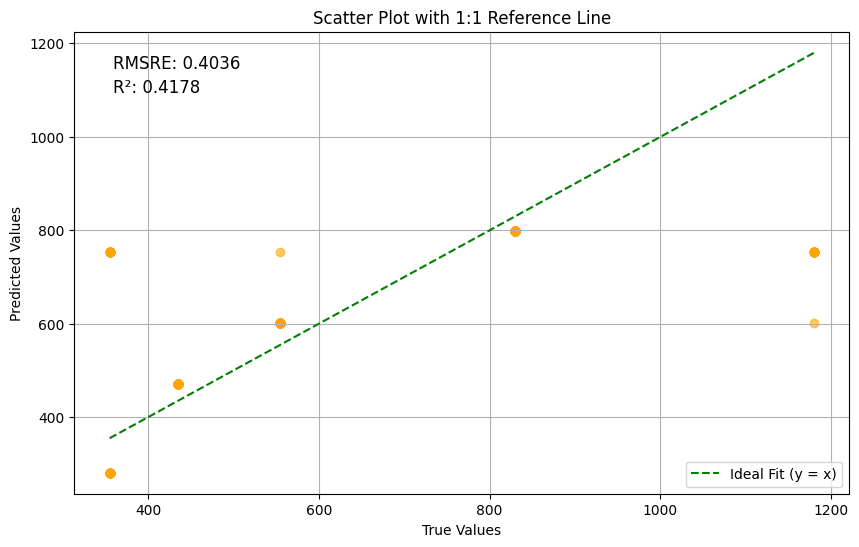

In [ ]:
plot_regression_curve(y_train_true, y_train_pred, best_model_rmsre, best_model_r2)

## Feature Importance Visualization

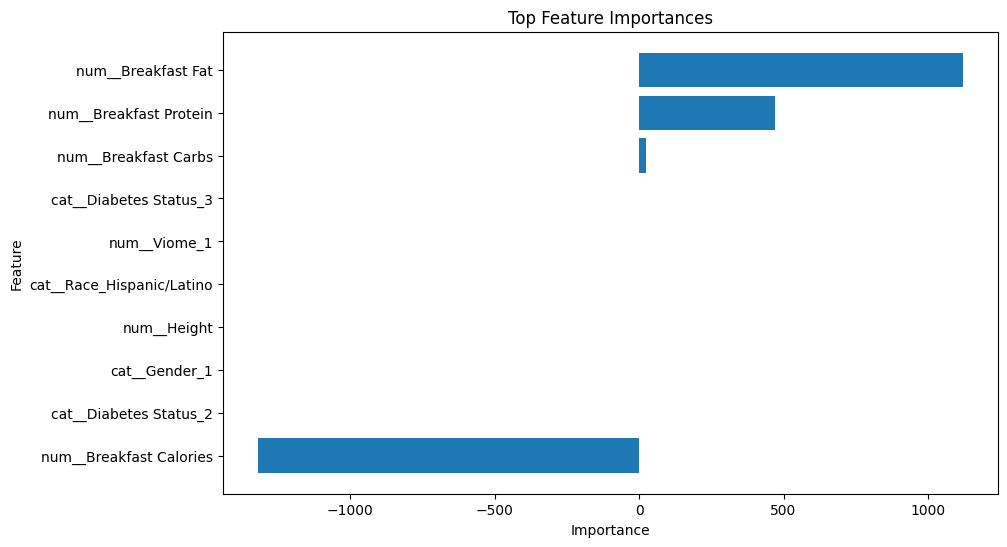

In [ ]:
try:
    fitted_preprocessor = best_model.named_steps['preprocessor']
    fitted_feature_selector = best_model.named_steps['feature_selection']
    fitted_model = best_model.named_steps['model']

    feature_importance_df = calculate_feature_importance(fitted_preprocessor, fitted_feature_selector, fitted_model)
    plot_feature_importance(feature_importance_df, top_n=20)
except ValueError as e:
    print(e)


## Prediction on Test Data

In [ ]:
demograph_test_df = viome_test.drop(columns = ["Viome"], axis = 1)
expanded_df_test = pd.DataFrame(
    viome_test['Viome'].to_list(), 
    columns=[f'Viome_{i}' for i in range(len(viome_test['Viome'][0]))])

# Combine with the original DataFrame (if needed)
df_test = pd.concat([demograph_test_df, expanded_df_test], axis=1)
combined_df_test = label_test.merge(df_test, on=['Subject ID'])
combined_df_test.drop(columns = ["Subject ID"], inplace = True)

In [ ]:
combined_df_test.head()

In [ ]:
# Make predictions on the test set
y_test_pred = best_model.predict(combined_df_test)
y_test_pred_df = pd.DataFrame(y_test_pred, columns = ['label'])
y_test_pred_df.head()

In [ ]:
submissions = y_test_pred_df.to_csv("Careful_model1.csv", index_label="row_id")